In [ ]:
!pip install overpy
!pip install geetools
!pip install rasterio
!pip install geemap

In [ ]:
!earthengine authenticate

In [2]:
import numpy as np
import pandas as pd
import overpy
import geopandas as gpd
import ee
from geetools import batch
import requests
from shapely.geometry import Polygon, box
import os
import rasterio
import rasterio.plot
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## OpenStreetMap API

In [4]:
api = overpy.Overpass()

# Fetch all wastewater treatment plants within California's boundary
query = f"""
    area[admin_level=4]["name"="California"]->.searchArea;
    (
      way["man_made"="wastewater_plant"](area.searchArea);
    );
    (._;>;);
    out body;
    """

result = api.query(query)

In [5]:
# Store results in desired format
plants = {}

for way in result.ways:
    # Use the name of the plant or its ID if the name is not available
    plant_name = way.tags.get("name", f"Plant_{way.id}")

    # Extract nodes lat and lon without id
    nodes_coords = [(node.lon, node.lat) for node in way.nodes]

    # get rid of "Decimal"  in the coordinates
    nodes_coords = [tuple(map(float, i)) for i in nodes_coords]

    plants[plant_name] = nodes_coords

In [7]:
geoms = [Polygon(plants[key]) for key in plants]
df = gpd.GeoDataFrame({'WWTP_name': list(plants.keys()), 'geometry': geoms}, crs="EPSG:4326")

## Google Earth Engine

To get max area

In [30]:
(df.to_crs('+proj=cea').area).idxmax()
(df.to_crs(epsg=3035).area).idxmax()

38

In [33]:
df.iloc[38]

WWTP_name    Fresno Clovis Regional Waste Water Treatment P...
geometry     POLYGON ((-119.9127492 36.7061639, -119.907394...
Name: 38, dtype: object

To get vertices of bounding box

In [53]:
df.iloc[0].geometry.exterior.coords.xy

(array('d', [-121.8093956, -121.805817, -121.8056706, -121.8056706, -121.8058937, -121.8059778, -121.8060333, -121.8061508, -121.8071187, -121.8095244, -121.8096322, -121.809724, -121.8097223, -121.809522, -121.8093956]),
 array('d', [37.6930507, 37.6930115, 37.6930099, 37.6904833, 37.6899807, 37.6894001, 37.6892735, 37.6892261, 37.6892498, 37.6896004, 37.6904367, 37.6914042, 37.6915312, 37.6915461, 37.6930507]))

To get centroid

In [57]:
df.to_crs('+proj=cea').centroid.to_crs(epsg=4326)

0       POINT (-121.80762 37.69120)
1       POINT (-121.78025 36.79990)
2       POINT (-122.29525 37.82512)
3       POINT (-118.43006 33.92574)
4       POINT (-121.94663 37.43156)
                   ...             
3101    POINT (-121.52255 38.56391)
3102    POINT (-118.94450 37.63989)
3103    POINT (-121.96297 38.67961)
3104    POINT (-120.46110 38.12511)
3105    POINT (-121.70127 38.87587)
Length: 3106, dtype: geometry

In [71]:
df["centroid"] = df.to_crs('+proj=cea').centroid.to_crs(epsg=4326)

NAIP dataset in Googel Earth Engine: https://developers.google.com/earth-engine/datasets/catalog/USDA_NAIP_DOQQ

ee.Geometry.Rectangle: https://github.com/gee-community/example-scripts/blob/master/Geometries/ee.Geometry.Rectangle.md

In [40]:
df_not_download = df.copy() # keep track of which plants have NOT been downloaded

In [ ]:
df.loc[:,'length'] = df.loc[:,'geometry'].bounds.maxx - df.loc[:,'geometry'].bounds.minx
df.loc[:, 'height'] = df.loc[:,'geometry'].bounds.maxy - df.loc[:,'geometry'].bounds.miny
df.head()

In [73]:
import geemap

In [77]:
downloaded_directory = "downloaded_images"
if not os.path.exists(downloaded_directory):
    os.mkdir(downloaded_directory)

for idx, row in df[:2].iterrows():
    # 1. Get the bounding box for the current wastewater treatment plant
    bbox = row.geometry.bounds

    # 2. Determine the length and height of the WWTP and double them
    length = 0.01
    height = 0.01
    center_x = row.centroid.x
    center_y = row.centroid.y

    print(center_x, center_y)

    large_polygon = ee.Geometry.Polygon([(center_x+length, center_y+height), (center_x+length, center_y-height),
     (center_x-length, center_y-height), (center_x-length, center_y+height)])

    feature = ee.Feature(large_polygon, {})

    collection = (
        ee.ImageCollection("USDA/NAIP/DOQQ")
        .filterDate("2018-01-01", "2019-01-01")
        .select(['R', 'G', 'B'])
    )

    image = ee.Image(collection.mosaic())

    roi = feature.geometry()

    filename = os.path.join(downloaded_directory, f"image.tif")

    image = image.clip(roi).unmask()
    geemap.ee_export_image(
          image, filename=filename, scale=1, region=roi, file_per_band=False
      )

    # download_naip(large_polygon,downloaded_directory,os.path.join(downloaded_directory, f"{row['WWTP_name']}.tif"))

-121.80761812443576 37.69120463483653
[-121.81261812443576, 37.68620463483653, -121.80261812443577, 37.69620463483653]
Generating URL ...
Please wait ...
Data downloaded to /content/downloaded_images/image.tif
-121.78025325269596 36.79990211309372
[-121.78525325269595, 36.79490211309372, -121.77525325269596, 36.804902113093725]
Generating URL ...
Please wait ...
Data downloaded to /content/downloaded_images/image.tif


download time:\
0.02x0.02: 14min\
0.01x0.01: 6min

## Plot bounding box on top of satellite image

In [ ]:
with rasterio.open('downloaded_images_2/EBMUD Wastewater Treatment Plant.tif') as src:
    # Read the image data
    img = src.read([1, 2, 3, 4])  # Reads the first three bands for RGB

df_EBMUD = df[df['WWTP_name'] == 'EBMUD Wastewater Treatment Plant']

# check
# Raster extent
left, bottom, right, top = src.bounds
print("Raster bounds:", left, bottom, right, top)

# Bounding box extent
minx, miny, maxx, maxy = df_EBMUD.geometry.total_bounds
print("Bounding box bounds:", minx, miny, maxx, maxy)

# raster geometry system
print("Raster CRS:", src.crs)

# bounding box geometry system
print("Bounding box CRS:", df_EBMUD.crs)

Raster bounds: -122.30073909772723 37.82005262509154 -122.29073186546213 37.83005985735663
Bounding box bounds: -122.2998075 37.8228337 -122.2916564 37.8272765
Raster CRS: EPSG:4326
Bounding box CRS: EPSG:4326


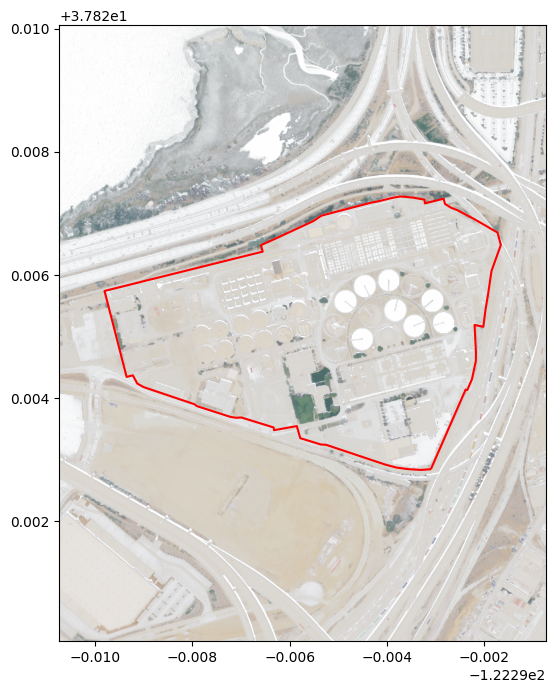

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

# Plot the raster
ax = rasterio.plot.show(img, ax=ax, transform=src.transform)

# Plot the bounding box
df_EBMUD.boundary.plot(ax=ax, color='red', linewidth=1.5)

plt.show()